In [1]:
!nvidia-smi

Mon Feb 17 13:31:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0    N/A /  N/A |    335MiB /  2002MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 1)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.layer4 = self.make_layer(block, 128, layers[1], 1)
        self.max_pool = torch.nn.MaxPool2d(8)
        self.fc = torch.nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = torch.load('/home/matvey/Morozov/Научрук/Диплом/Модель/Models/FashionMNIST_ResNet.pth')
net.eval()

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [6]:
test_tf = transforms.Compose([
    transforms.ToTensor()
])

test = torchvision.datasets.FashionMNIST('Модель/Datasets', download=False, train=False, transform=test_tf)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

### SimBA

In [7]:
import utils

/home/matvey/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [8]:
def normalize(x):
    return utils.apply_normalization(x, 'cifar')

def get_probs(model, x, y):
    output = model(normalize(x.cuda())).cpu()
    probs = torch.nn.Softmax()(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[torch.randint(0, 28*28, (1,))[0]] = epsilon     
        left_prob = get_probs(model, (x - diff.view(x.size()).to(device)).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size()).to(device)).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size()).to(device)).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size()).to(device)).clamp(0, 1)
                last_prob = right_prob
    return x

In [9]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
from scipy.special import softmax

In [11]:
from numpy.linalg import norm

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


2.5887 4.6352944


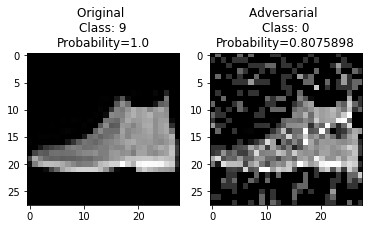

2.3257198 4.6


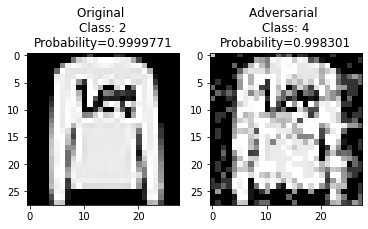

0.0 0.0


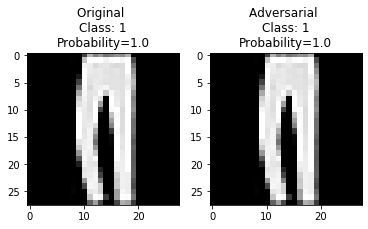

2.391385 4.541177


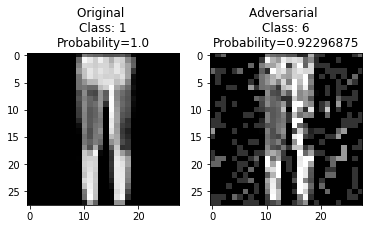

2.2367988 5.1999993


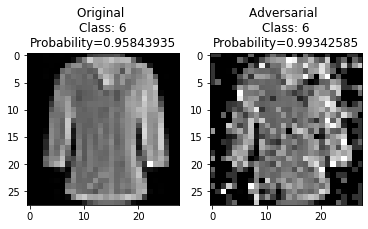

In [12]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])

    x = simba_single(net, example_data[i].reshape(1, 1, 28, 28).to(device), torch.tensor(example_targets[i]).to(device), num_iters=1000, epsilon=0.2)

    prob_adv = softmax(net(x.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])
    
    init_image = example.data.cpu().numpy()[0]
    adv_image = x.data.cpu().numpy()[0][0]
    
    l2 = norm(init_image - adv_image, ord=2)
    l1 = norm(init_image - adv_image, ord=1)
    print(l2, l1)

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(init_image, cmap='gray')
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    axes[1].imshow(adv_image, cmap='gray')
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

## Fast gradient sign method

In [13]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [14]:
loss = torch.nn.CrossEntropyLoss()
example_data, example_targets = example_data.to(device), example_targets.to(device)
example_data.requires_grad = True
output = net(example_data)

loss_val = loss(output, example_targets)

net.zero_grad()
loss_val.backward()

data_grad = example_data.grad.data

0.35988685 0.71999973


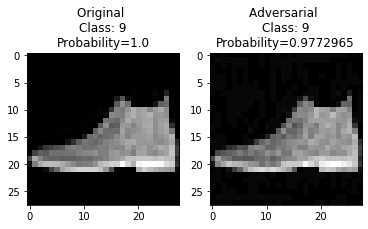

0.36489284 0.80999935


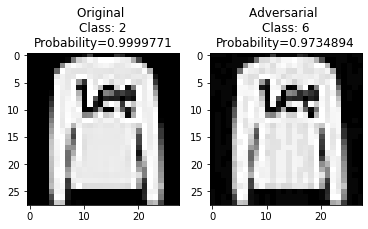

0.37066752 0.83999956


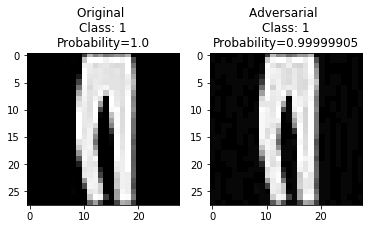

0.39649943 0.83999956


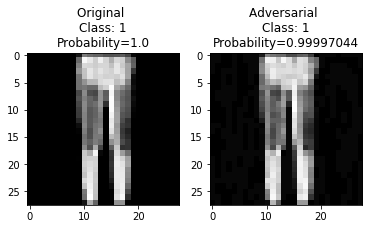

0.30354974 0.8399997


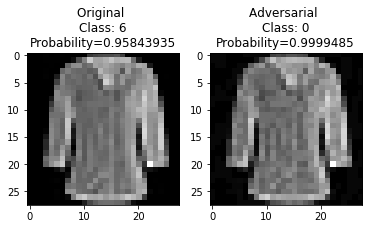

In [15]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])

    x = fgsm_attack(example_data[i], 0.03, data_grad[i])
    prob_adv = softmax(net(x.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])
    
    init_image = example.data.cpu().numpy()[0]
    adv_image = x.data.cpu().numpy()[0]
    
    l2 = norm(init_image - adv_image, ord=2)
    l1 = norm(init_image - adv_image, ord=1)
    print(l2, l1)

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(init_image, cmap='gray')
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))

    axes[1].imshow(adv_image, cmap='gray')
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

## Iterative Fast gradient sign method.

In [16]:
torch.retain_graph=True
loss_val = loss(output, example_targets)

In [17]:
def ifgsm_attack(example_data, example_targets, net, loss, epsilon, iteration=1):
    example_data_copy = example_data
    
    for i in range(iteration):
        output = net(example_data)
        loss_val = loss(output, example_targets)

        net.zero_grad()
        loss_val.backward()
        data_grad = example_data.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_images = example_data + epsilon*sign_data_grad
        perturbed_images = torch.clamp(perturbed_images, 0, 1)     
        example_data = torch.tensor(perturbed_images, requires_grad=True) 
        
    example_data = example_data_copy
        
    return perturbed_images

In [18]:
retain_graph=True
perturbed_images = ifgsm_attack(example_data, example_targets, net, loss, 0.01, iteration=10)

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.5054565 1.19


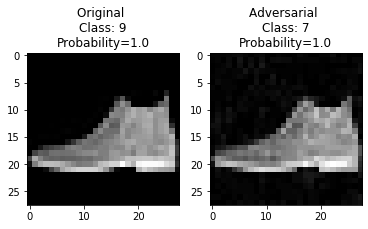

0.72015 1.8499986


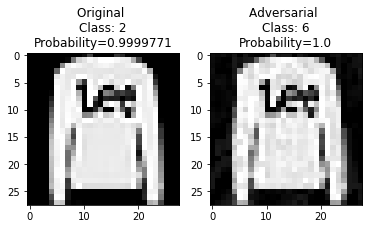

0.7141091 1.6599984


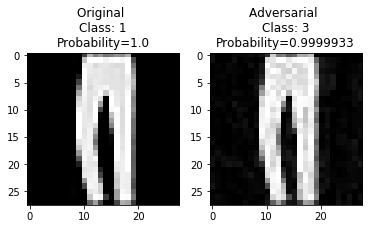

0.74335945 1.8399997


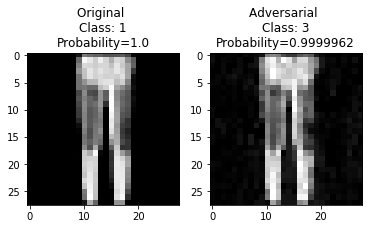

0.5485709 1.4799988


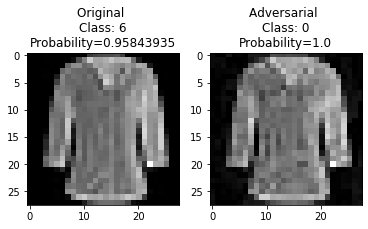

In [19]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])
    x = perturbed_images[i]
    prob_adv = softmax(net(x.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])
    
    init_image = example.data.cpu().numpy()[0]
    adv_image = x.data.cpu().numpy()[0]
    
    l2 = norm(init_image - adv_image, ord=2)
    l1 = norm(init_image - adv_image, ord=1)
    print(l2, l1)

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(example.data.cpu().numpy()[0], cmap='gray')
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))

    axes[1].imshow(x.data.cpu().numpy()[0], cmap='gray')
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

### Our method

In [20]:
from numpy.linalg import norm

In [21]:
train = torchvision.datasets.FashionMNIST('Модель/Datasets', download=False, train=True, transform=test_tf)
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=10000, shuffle=False)

In [22]:
examples_train = enumerate(trainloader)
batch_idx, (train_data, train_targets) = next(examples)

In [23]:
train_data = train_data.to(device)
train_targets = train_targets.to(device)

In [24]:
def nearest_image(image, label, train_data, train_targets):
    image = image.data.cpu().numpy()[0]
    all_norm = []
    for i, train_image in enumerate(train_data):
        if train_targets[i].data.cpu().numpy() != label:
            train_image = train_image.data.cpu().numpy()
            diff = train_image - image
            norm_diff = norm(diff)
            all_norm.append(norm_diff)
        else:
            all_norm.append(1e20)            

    index = np.argmin(all_norm)
    return index

def out_attack(image, label, train_data, train_targets, eps):
    index = nearest_image(image, label, train_data, train_targets)
    res = image + eps * (train_data[index] - image)
    return res.clamp(0, 255)

2.0780945 3.6729412


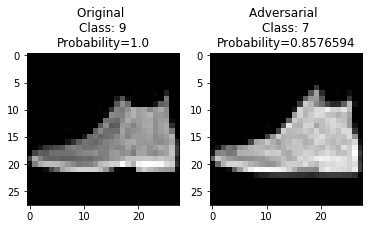

2.484622 4.1152945


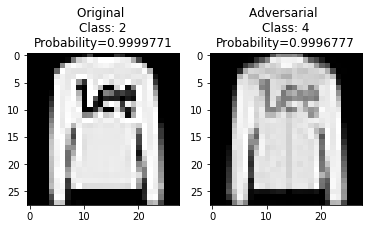

3.2351248 10.152942


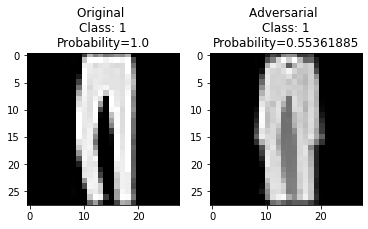

2.4120731 8.08706


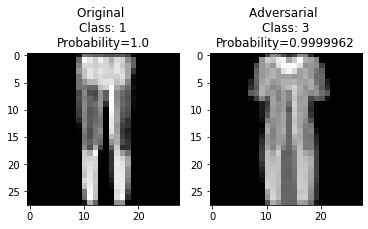

1.4228351 3.127059


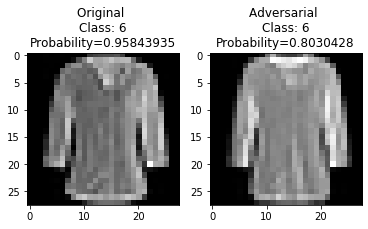

2.7704608 6.614118


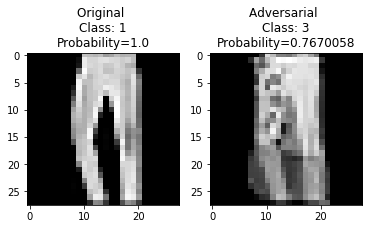

In [25]:
for i in range(6):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])        

    init_image = example.data.cpu().numpy()[0]
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(init_image, cmap='gray')    
    axes[0].set_title('Original ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_original)) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    x = out_attack(example, example_targets[i].data.cpu().numpy(), train_data, train_targets, 0.6)
    prob_adv = softmax(net(x.reshape(1, 1, 28, 28).to(device)).data.cpu().numpy()[0])

    adv_image = x.data.cpu().numpy()[0]
    
    l2 = norm(init_image - adv_image, ord=2)
    l1 = norm(init_image - adv_image, ord=1)
    print(l2, l1)
    axes[1].imshow(adv_image, cmap='gray')
    axes[1].set_title('Adversarial ' + '\n'
                      + 'Class: '+ str(np.argmax(prob_adv)) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))

    plt.show()

###  Boundary Attack

In [26]:
import sys

In [27]:
#ортогональный шаг
def orthogonal_perturbation(delta, prev_sample, target_sample):
    perturb = np.random.randn(28, 28)
    perturb /= np.linalg.norm(perturb, ord=2)
    perturb *= delta * np.linalg.norm(target_sample - prev_sample, ord=2)
    
    mean = np.mean(prev_sample)
    
    #Проекция шума на сферу вокруг целевой точки
    diff = target_sample - prev_sample
    diff /= np.linalg.norm(target_sample - prev_sample, ord=2)
    
    perturb -= np.dot(perturb, diff) * diff
    
    overflow = (prev_sample + perturb) - np.ones((28, 28)) * (255. - mean)
    perturb -= overflow * (overflow > 0)
    underflow = -(prev_sample + perturb) + np.ones((28, 28)) * (0. - mean)
    perturb += underflow * (underflow > 0)
    return perturb

#прямой шаг
def forward_perturbation(epsilon, prev_sample, target_sample):
    perturb = target_sample - prev_sample
    perturb /= np.linalg.norm(target_sample - prev_sample, ord=2)
    perturb *= epsilon
    return perturb

In [28]:
def boundary_attack(net, initial_image, target_image):
    print('Start boundary attack')
    predict_init = net(torch.tensor(initial_image.reshape(1, 1, 28, 28)).to(device)).data.cpu().numpy()
    predict_target = net(torch.tensor(target_image.reshape(1, 1, 28, 28)).to(device)).data.cpu().numpy()
    
    attack_class = np.argmax(predict_init)
    target_class = np.argmax(predict_target)

    adversarial_sample = initial_image
    
    n_steps = 0
    n_calls = 0
    epsilon = 1.
    delta = 0.1

    #Шаг 1. Находим проекцию на границу адверсальности
    while True:
        trial_sample = adversarial_sample + forward_perturbation(epsilon * np.linalg.norm(adversarial_sample - target_image, ord=2), adversarial_sample, target_image)
        prediction = net(torch.tensor(trial_sample.reshape(1, 1, 28, 28)).to(device)).data.cpu().numpy()
        n_calls += 1
        if np.argmax(prediction) == attack_class:
            adversarial_sample = trial_sample
            break
        else:
            epsilon *= 0.9

    #Шаг 2. Дельта шаг
    while True:
        d_step = 0
        while True:
            d_step += 1
            trial_samples = []
            for i in np.arange(10):
                trial_sample = adversarial_sample + orthogonal_perturbation(delta, adversarial_sample, target_image)
                trial_samples.append(trial_sample)
            trial_samples = np.array(trial_samples)
            predictions = net(torch.tensor(trial_samples.reshape(10, 1, 28, 28)).to(device, dtype=torch.float)).data.cpu().numpy()
            n_calls += 10
            predictions = np.argmax(predictions, axis=1)
            d_score = np.mean(predictions == attack_class)
            if d_score > 0.0:
                if d_score < 0.3:
                    delta *= 0.9
                elif d_score > 0.7:
                    delta /= 0.9
                adversarial_sample = np.array(trial_samples)[np.where(predictions == attack_class)[0][0]]
                break
            else:
                delta *= 0.9
        e_step = 0
        
        while True:
            e_step += 1
            trial_sample = adversarial_sample + forward_perturbation(epsilon * np.linalg.norm(adversarial_sample - target_image, ord=2), adversarial_sample, target_image)
            prediction = net(torch.tensor(trial_sample.reshape(1, 1, 28, 28)).to(device, dtype=torch.float)).data.cpu().numpy()
            n_calls += 1
            if np.argmax(prediction) == attack_class:
                adversarial_sample = trial_sample
                epsilon /= 0.5
                break
            elif e_step > 500:
                    break
            else:
                epsilon *= 0.5
        n_steps += 1
        
        diff = np.linalg.norm(adversarial_sample - target_image, ord=2)
        sys.stdout.write("\rdistance: %0.4f" % (diff, ))
        if diff <= 0.1 or e_step > 500:
            break
            
    return adversarial_sample

### Target example

In [29]:
x_init = example_data[10].reshape(28, 28)
x_init = x_init.data.cpu().numpy()

In [30]:
pred = net(torch.tensor(x_init.reshape(1,1,28,28)).to(device, dtype=torch.float))
print(np.argmax((pred.data.cpu().numpy())[0]))

4


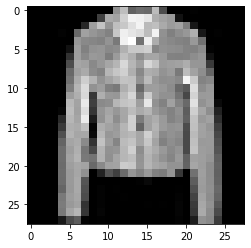

In [31]:
plt.imshow(x_init, cmap='gray')

### Attacked example

In [32]:
x_target = example_data[0].reshape(28, 28)
x_target = x_target.data.cpu().numpy()

In [33]:
pred = net(torch.tensor(x_target.reshape(1,1,28,28)).to(device, dtype=torch.float))
print(np.argmax((pred.data.cpu().numpy())[0]))

9


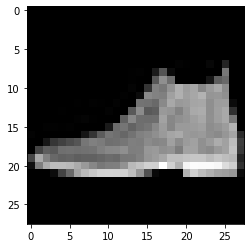

In [34]:
plt.imshow(x_target, cmap='gray')

### Advertasial example

In [ ]:
adv_example = boundary_attack(net, x_init, x_target)

Start boundary attack
distance: 0.1226

In [ ]:
plt.imshow(adv_example, cmap='gray')

In [ ]:
pred = net(torch.tensor(adv_example.reshape(1,1,28,28)).to(device, dtype=torch.float))
print(np.argmax((pred.data.cpu().numpy())[0]))